# Cats & Dogs(Pytorch CNN Demo)

## Importing Libraries, Getting Dataset, Visualizing Data

In [1]:
# Getting the dataset
import opendatasets as od

od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces", data_dir='datasets')

Skipping, found downloaded files in "datasets\animal-faces" (use force=True to force download)


In [2]:
# Importing libraries

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
print(device)

cuda


In [4]:
image_path = []
labels = []

for i in os.listdir("C:\\Work\\VS Code\\ml-research-project\\datasets\\animal-faces\\afhq\\"):
    for label in os.listdir(f"C:\\Work\\VS Code\\ml-research-project\\datasets\\animal-faces\\afhq\\{i}"):
        for image in os.listdir(f"C:\\Work\\VS Code\\ml-research-project\\datasets\\animal-faces\\afhq\\{i}\\{label}"):
            labels.append(label)
            image_path.append(f"C:\\Work\\VS Code\\ml-research-project\\datasets\\animal-faces\\afhq\\{i}\\{label}\\{image}")

data_df = pd.DataFrame(zip(image_path, labels), columns=['image_paths', 'labels'])
data_df.head()

,image_paths,labels
0,C:\Work\VS Code\ml-research-project\datasets\a...,cat
1,C:\Work\VS Code\ml-research-project\datasets\a...,cat
2,C:\Work\VS Code\ml-research-project\datasets\a...,cat
3,C:\Work\VS Code\ml-research-project\datasets\a...,cat
4,C:\Work\VS Code\ml-research-project\datasets\a...,cat


In [5]:
train = data_df.sample(frac=0.7, random_state=7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=7)
test = test.drop(val.index)

In [6]:
train.head()

,image_paths,labels
12388,C:\Work\VS Code\ml-research-project\datasets\a...,wild
6596,C:\Work\VS Code\ml-research-project\datasets\a...,dog
5367,C:\Work\VS Code\ml-research-project\datasets\a...,dog
13331,C:\Work\VS Code\ml-research-project\datasets\a...,wild
14958,C:\Work\VS Code\ml-research-project\datasets\a...,cat


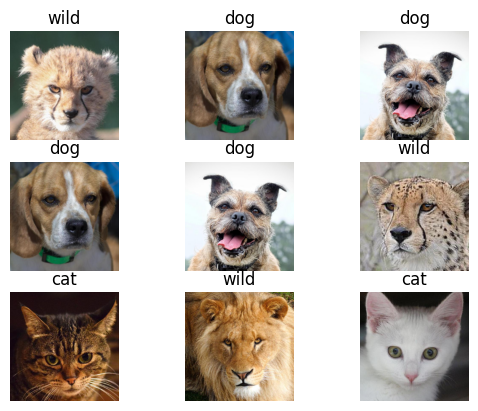

In [7]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
c = 0
for row in range(n_rows):
    for col in range(n_cols):
        tuple = train.iloc[c * row + col]
        image = Image.open(tuple['image_paths']).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis('off')
        axarr[row, col].set_title(tuple['labels'])
    c += 1

plt.show()

## Data Preprocessing

In [8]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

LabelEncoder()

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    lambda x: x.to(torch.float)
])

## Hyperparameters

In [10]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
EPOCHS = 10

## Dataset & Dataloaders

In [11]:
class dataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, ind):
        img_path = self.dataframe['image_paths'].iloc[ind]
        label = self.labels[ind]
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image).to(device)
        return image, label

In [12]:
train_dataset = dataset(dataframe=train, transform=transform)
val_dataset = dataset(dataframe=val, transform=transform)
test_dataset = dataset(dataframe=test, transform=transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Model Building & Training

In [14]:
# Building the model

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=3, padding=1)
        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 5, 128)
        self.output = nn.Linear(128, len(data_df['labels'].unique()))


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pooling(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)

        return x

In [15]:
model = MyModel().to(device)

In [16]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 11, 11]          73,856
              ReLU-8          [-1, 128, 11, 11]               0
         MaxPool2d-9            [-1, 128, 5, 5]               0
          Flatten-10                 [-1, 3200]               0
           Linear-11                  [-1, 128]         409,728
           Linear-12                    [-1, 3]             387
Total params: 503,363
Trainable params: 503,363
Non-trainable params: 0
-------------------------------

In [17]:
# Loss & optimizer

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        pred = model(inputs)
        batch_loss = criterion(pred, labels)
        epoch_loss += batch_loss.item()
        batch_acc = (torch.argmax(pred, dim=1) == labels).sum().item()
        epoch_acc += batch_acc

        batch_loss.backward()
        optimizer.step()

    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = epoch_acc / len(train_dataset) * 100

    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))

    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            pred = model(inputs)
            batch_loss = criterion(pred, labels)
            val_loss += batch_loss.item()
            batch_acc = (torch.argmax(pred, dim=1) == labels).sum().item()
            val_acc += batch_acc

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_acc / len(val_dataset) * 100

    total_loss_validation_plot.append(round(avg_val_loss, 4))
    total_acc_validation_plot.append(round(val_accuracy, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, 
    Train Loss: {round(avg_train_loss, 4)} | Train Accuracy: {round(train_accuracy, 4)}%
    Validation Loss: {round(avg_val_loss, 4)} | Validation Accuracy: {round(val_accuracy, 4)}%''')
    print("="*50)


Epoch 1/10, 
    Train Loss: 0.5292 | Train Accuracy: 76.592%
    Validation Loss: 0.234 | Validation Accuracy: 91.5702%
Epoch 2/10, 
    Train Loss: 0.2048 | Train Accuracy: 92.4099%
    Validation Loss: 0.1546 | Validation Accuracy: 94.3802%
Epoch 3/10, 
    Train Loss: 0.1433 | Train Accuracy: 94.7923%
    Validation Loss: 0.1452 | Validation Accuracy: 94.9174%
Epoch 4/10, 
    Train Loss: 0.0986 | Train Accuracy: 96.2802%
    Validation Loss: 0.1478 | Validation Accuracy: 95.2066%
Epoch 5/10, 
    Train Loss: 0.0838 | Train Accuracy: 96.9268%
    Validation Loss: 0.1549 | Validation Accuracy: 95.2479%
Epoch 6/10, 
    Train Loss: 0.0648 | Train Accuracy: 97.4759%
    Validation Loss: 0.145 | Validation Accuracy: 95.6612%
Epoch 7/10, 
    Train Loss: 0.0598 | Train Accuracy: 97.8213%
    Validation Loss: 0.1326 | Validation Accuracy: 95.8678%
Epoch 8/10, 
    Train Loss: 0.0409 | Train Accuracy: 98.5652%
    Validation Loss: 0.1719 | Validation Accuracy: 95.4959%
Epoch 9/10, 
    Tr

In [20]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      predictions = model(inputs)

      acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
      total_acc_test += acc
      test_loss = criterion(predictions, labels)
      total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 94.9979 and Loss is 0.0294
